In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.feature_extraction import text
from sklearn.metrics import confusion_matrix, roc_auc_score
 
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

import re
from string import punctuation

from sklearn.model_selection import train_test_split
from collections import Counter

import numpy as np

import tensorflow as tf
from keras.callbacks import EarlyStopping

Download data from kaggle and put into local directory: 
https://www.kaggle.com/competitions/llm-detect-ai-generated-text/data + 
https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset

<h2>Prepare Data</h2>

In [2]:
df_prompts = pd.read_csv('train_prompts.csv')

df_essays = pd.read_csv('train_essays.csv')
df_essays = df_essays[['text', 'generated']]

In [3]:
df_essays.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [4]:
def plot_counts(df):
    generated_counts = df['generated'].value_counts()

    print(generated_counts)
    plt.bar(generated_counts.index, generated_counts.values, color=['red', 'blue'])
    
    #plt.gca().get_xaxis().set_ticks([])
    #plt.gca().get_yaxis().set_ticks([])
    
    plt.xticks(generated_counts.index, ['0', '1'])
    plt.yticks(generated_counts.values)
    
    plt.xlabel('Value')
    plt.ylabel('Num essay')

    plt.show()

generated
0    1375
1       3
Name: count, dtype: int64


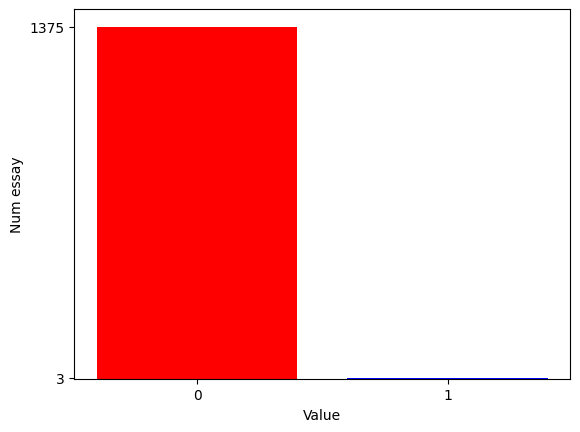

In [5]:
plot_counts(df_essays)

In [6]:
df_essays2 = pd.read_csv('train_v2_drcat_02.csv')
df_essays2 = df_essays2[['text', 'label']]
df_essays2.rename(columns={'label':'generated'}, inplace=True)

In [7]:
df_essays2

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0
...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1
44864,"Dear Senator,\n\nI am writing to you today to ...",1
44865,"Dear Senator,\n\nI am writing to you today to ...",1
44866,"Dear Senator,\n\nI am writing to you today to ...",1


In [8]:
df = pd.concat([df_essays, df_essays2], axis=0)
df.drop_duplicates(subset=['text'],inplace=True)
df.reset_index(drop=True,inplace=True)

generated
0    27371
1    17497
Name: count, dtype: int64


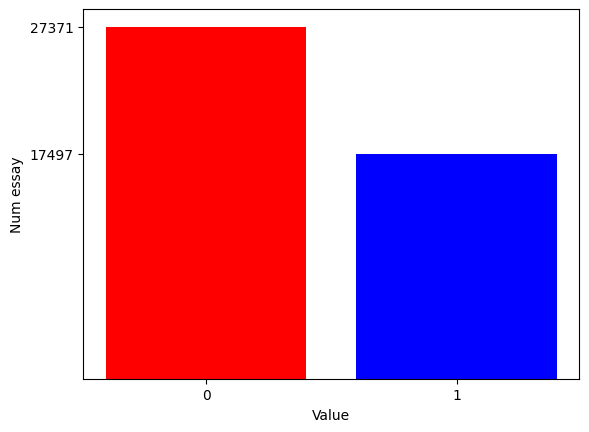

In [9]:
plot_counts(df)

In [10]:
stop_sklearn = text.ENGLISH_STOP_WORDS
stop_nltk = list(stopwords.words('english'))

stop_words = list(set(list(stop_sklearn) + stop_nltk))

def remove_stop_words(text):
    tokens = text.split()
    clean_tokens = [t for t in tokens if not t in stop_words]
    clean_text = " ".join(clean_tokens)
    return clean_text

def preprocess_text(text):
    text = text.lower()
    text = " ".join(text.split())
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)
    text = remove_stop_words(text)
    return text

In [11]:
df["text"] = df["text"].map(preprocess_text)

In [12]:
X = df['text']
y = df['generated']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
train_df = pd.concat([X_train, y_train], axis=1)   
test_df = pd.concat([X_test, y_test], axis=1)   

print(len(train_df), len(test_df))

35894 8974


In [13]:
words = (' '.join(train_df['text'])).split()
frequency = Counter(words)

words = list(frequency.keys())
frequencies = list(frequency.values())

sorted_indices = np.argsort(frequencies)
sorted_frequencies = [frequencies[i] for i in sorted_indices]
sorted_words = [words[i] for i in sorted_indices]
index_third_quartile = int(np.percentile(np.arange(len(sorted_frequencies)), 90))
top_words = [(sorted_words[i], sorted_frequencies[i]) for i in range(index_third_quartile, len(sorted_words))]
frequent_words = len(top_words)

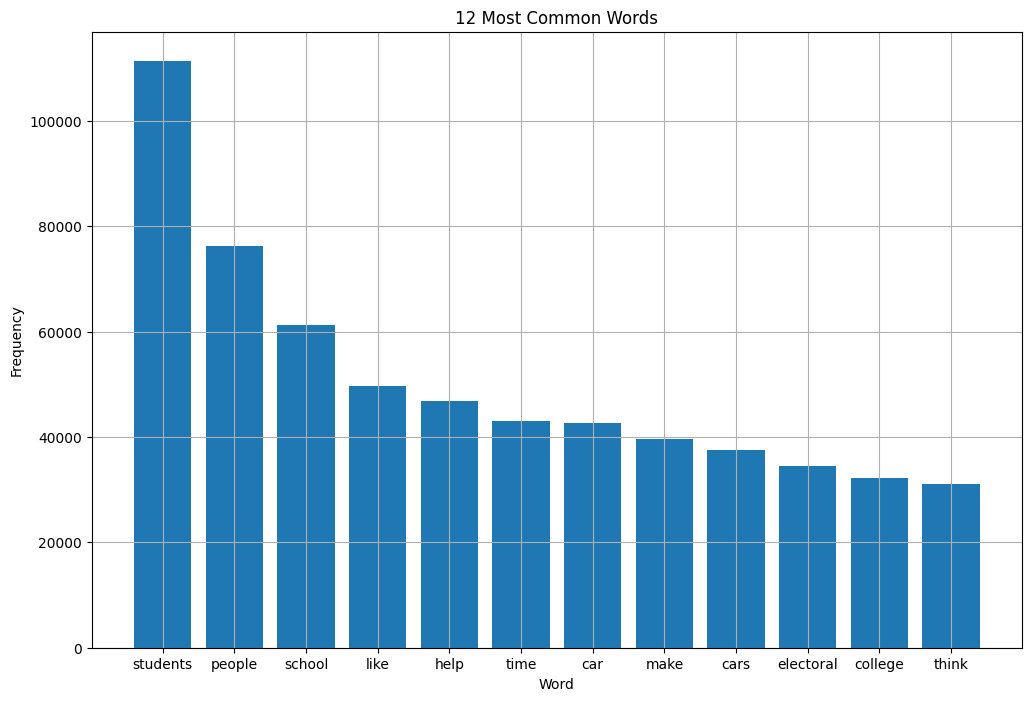

In [14]:
plt.figure(figsize=(12, 8))
plt.bar(*zip(*sorted(top_words, key=lambda x: -x[1])[:12]))
plt.title('12 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [15]:
sequence_lengths = list(map(lambda x: len(x.split()), df['text']))
third_quartile = np.percentile(sequence_lengths, 75)

print(third_quartile)
print(np.mean(sequence_lengths))

205.0
171.68041811536062


In [16]:
encoder = tf.keras.layers.TextVectorization(output_sequence_length=int(third_quartile), max_tokens=frequent_words)
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['text'], train_df['generated']))
encoder.adapt(train_dataset.map(lambda text, label: text))

#sequence_lengths = list(map(lambda x, len(x), encoder(train_df['text'])))

In [17]:
print("------------------------------------ORIGINAL------------------------------------")
print(train_df['text'][0])
print("------------------------------------ENCODED------------------------------------")
print(encoder(train_df['text'][0]))

------------------------------------ORIGINAL------------------------------------
cars cars famous 1900s henry ford created built modelt cars played major role day lives people starting question limiting car usage good thing limiting use cars good thing like matter article german suburb life goes cars elizabeth rosenthal states automobiles linchpin suburbs middle class families shanghai chicago tend make homes experts say huge impediment current efforts reduce greenhouse gas emissions tailpipe passenger cars responsible 12 percent greenhouse gas emissions europeand 50 percent carintensive areas united states cars main reason greenhouse gas emissions lot people driving time getting need article paris bans driving smog robert duffer says paris days nearrecord pollution enforced partial driving ban clear air global city says monday motorist evennumbered license plates ordered leave cars home fined 22euro fine 31 order applied oddnumbered plates following day cars reason polluting entire ci

In [18]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 1024, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2, restore_best_weights=True)
fit_history = model.fit(X_train, y_train, epochs=100, batch_size=64,validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 269s 467ms/step - accuracy: 0.8614 - loss: 0.3067 - val_accuracy: 0.9863 - val_loss: 0.0524
Epoch 2/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 257s 458ms/step - accuracy: 0.9868 - loss: 0.0568 - val_accuracy: 0.9889 - val_loss: 0.0427
Epoch 3/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 261s 466ms/step - accuracy: 0.9916 - loss: 0.0298 - val_accuracy: 0.9891 - val_loss: 0.0422
Epoch 4/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 263s 469ms/step - accuracy: 0.9909 - loss: 0.0301 - val_accuracy: 0.9896 - val_loss: 0.0562


In [20]:
prediction = model.predict(X_test)
prediction = np.where(prediction > 0.5, 1, 0)

loss, accuracy = model.evaluate(X_test, y_test)
conf_matrix = confusion_matrix(y_test, prediction)
auc_score = roc_auc_score(y_test, prediction)

print("MODEL METRICS")
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Area Under the Curve: {auc_score}")
print(f"Confusion Matrix:")
print(conf_matrix)

281/281 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.9877 - loss: 0.0424
MODEL METRICS
Loss: 0.04269641637802124
Accuracy: 0.9888566732406616
Area Under the Curve: 0.9876801535212149
Confusion Matrix:
[[5406   37]
 [  63 3468]]


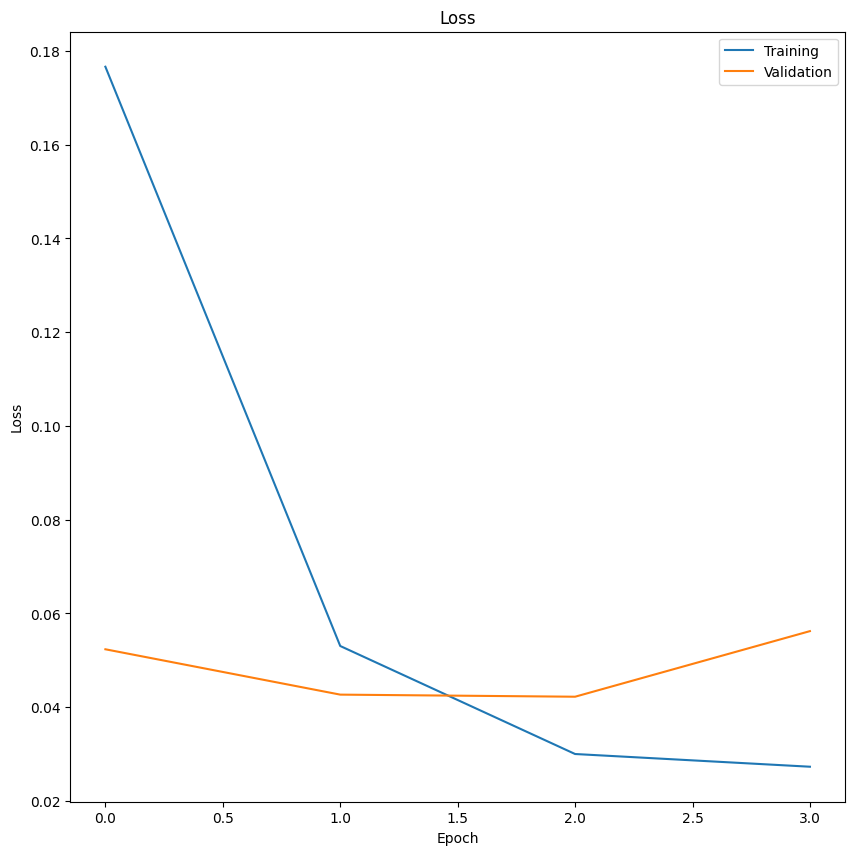

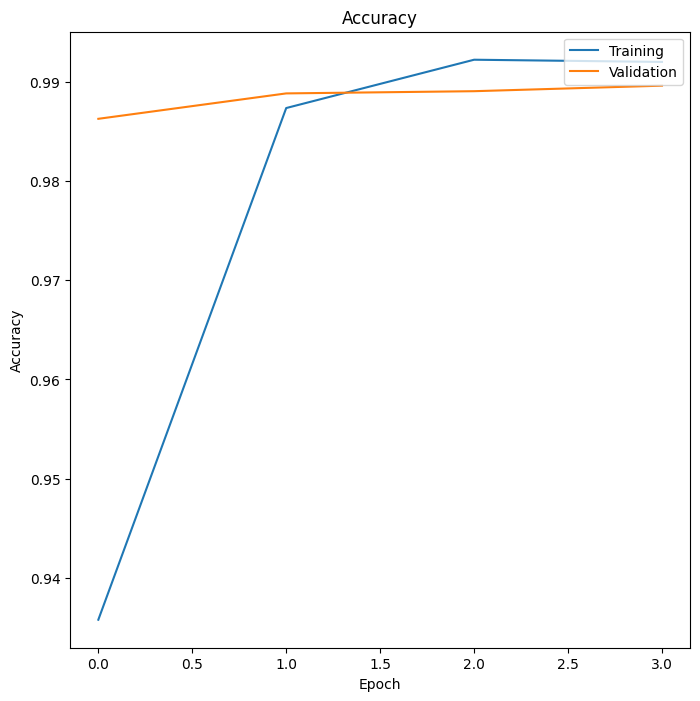

In [21]:
plt.figure(figsize=(10, 10))
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.figure(figsize=(8, 8))
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')